## AirBnB KNN Implementation

### Introduction

AirBnB is a marketplace for short term rentals that allows you to list part or all of your living space for others to rent. You can rent everything from a room in an apartment to your entire house on AirBnB. Because most of the listings are on a short-term basis, AirBnB has grown to become a popular alternative to hotels. The company itself has grown from it's founding in 2008 to a 30 billion dollar valuation in 2016 and is currently worth more than any hotel chain in the world.

One challenge that hosts looking to rent their living space face is determining the optimal nightly rent price. In many areas, renters are presented with a good selection of listings and can filter on criteria like price, number of bedrooms, room type and more. Since AirBnB is a marketplace, the amount a host can charge on a nightly basis is closely linked to the dynamics of the marketplace. Here's a screenshot of the search experience on AirBnB:

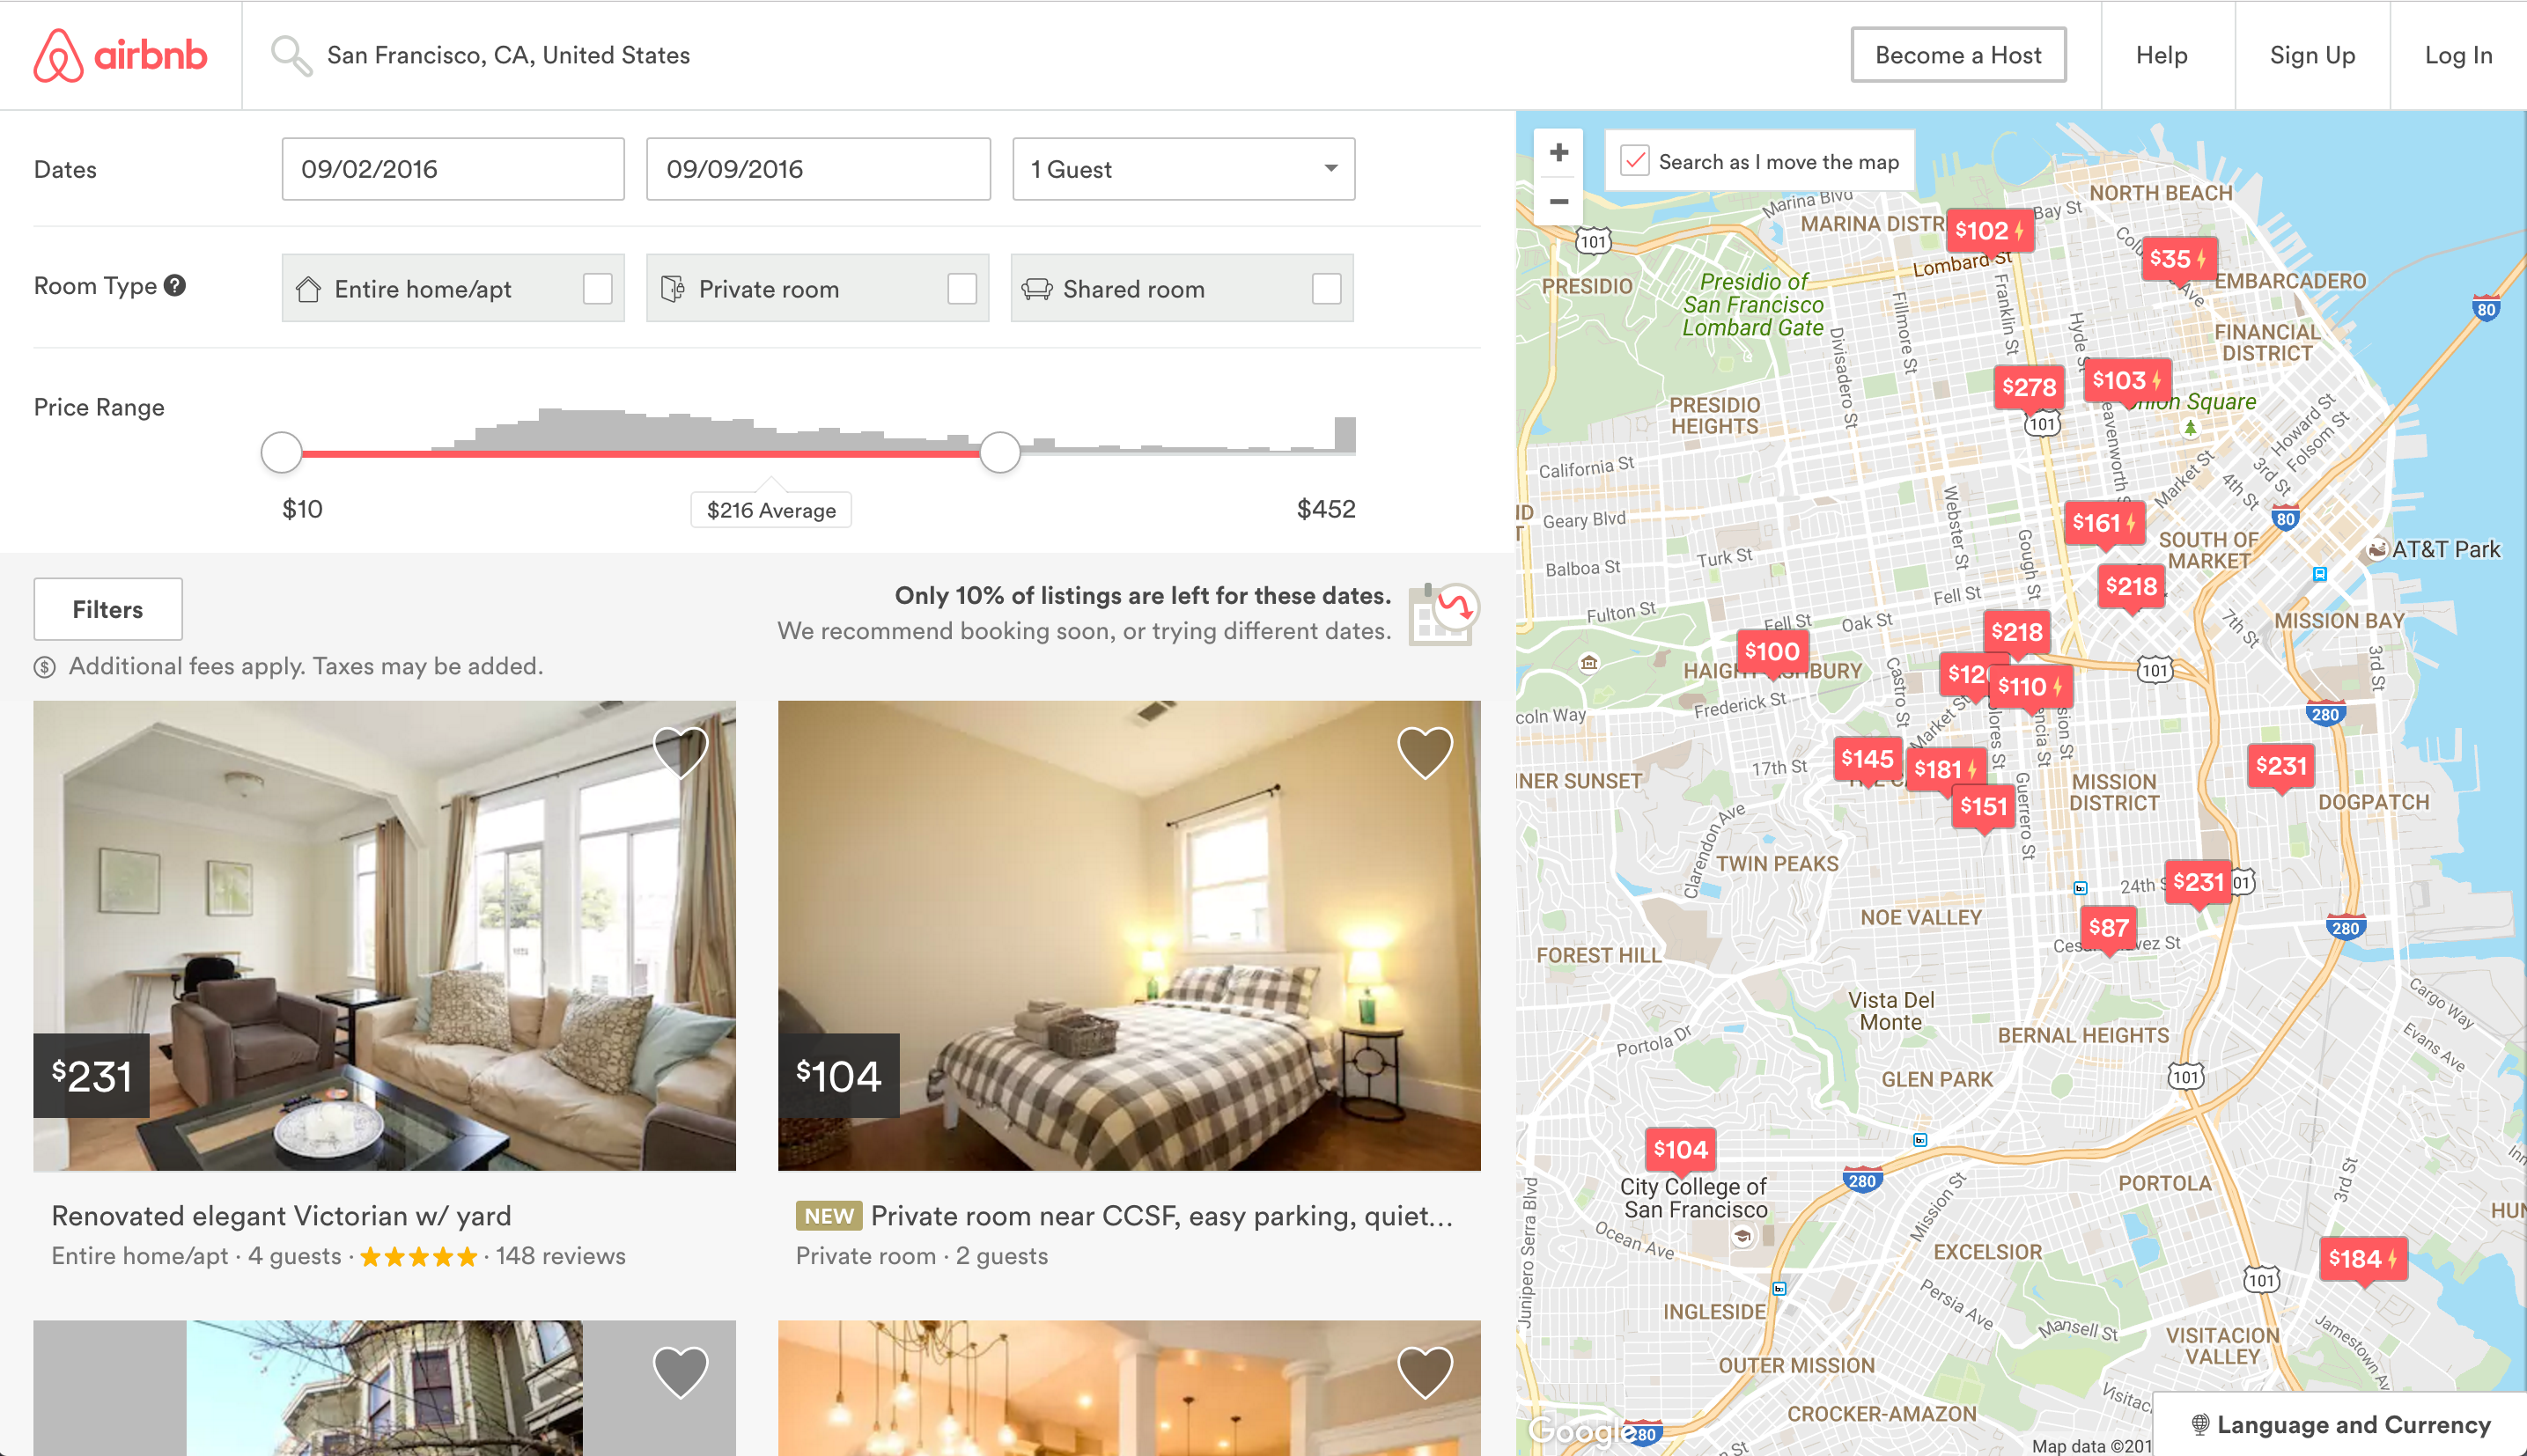

As a host, if we try to charge above market price for a living space we'd like to rent, then renters will select more affordable alternatives which are similar to ours.. If we set our nightly rent price too low, we'll miss out on potential revenue.

One strategy we could use is to:

1. find a few listings that are similar to ours,
2. average the listed price for the ones most similar to ours,
3. set our listing price to this calculated average price.

The process of discovering patterns in existing data to make a prediction is called machine learning. In our case, we want to use data on local listings to predict the optimal price for us to set. In this mission, we'll explore a specific machine learning technique called k-nearest neighbors, which mirrors the strategy we just described. Before we dive further into machine learning and k-nearest neighbors, let's get familiar with the dataset we'll be working with.

## Understanding the data

While AirBnB doesn't release any data on the listings in their marketplace, a separate group named Inside AirBnB has extracted data on a sample of the listings for many of the major cities on the website. In this post, we'll be working with their dataset from October 3, 2015 on the listings from Washington, D.C., the capital of the United States. Here's a direct link to that dataset (http://data.insideairbnb.com/united-states/dc/washington-dc/2015-10-03/data/listings.csv.gz). Each row in the dataset is a specific listing that's available for renting on AirBnB in the Washington, D.C. area

To make the dataset less cumbersome to work with, we'll be removing many of the columns in the original dataset. Here are the columns we will be keeping:

- host_response_rate: the response rate of the host
- host_acceptance_rate: number of requests to the host that convert to rentals
- host_listings_count: number of other listings the host has
- latitude: latitude dimension of the geographic coordinates
- longitude: longitude part of the coordinates
- city: the city the living space resides
- zipcode: the zip code the living space resides
- state: the state the living space resides
- accommodates: the number of guests the rental can accommodate
- room_type: the type of living space (Private room, Shared room or Entire home/apt
- bedrooms: number of bedrooms included in the rental
- bathrooms: number of bathrooms included in the rental
- beds: number of beds included in the rental
- price: nightly price for the rental
- cleaning_fee: additional fee used for cleaning the living space after the guest leaves
- security_deposit: refundable security deposit, in case of damages
- minimum_nights: minimum number of nights a guest can stay for the rental
- maximum_nights: maximum number of nights a guest can stay for the rental
- number_of_reviews: number of reviews that previous guests have left

Let's read the dataset into Pandas and become more familiar with it.

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv("listings.csv")

data.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,7087327,https://www.airbnb.com/rooms/7087327,20151002231825,2015-10-03,Historic DC Condo-Walk to Capitol!,Professional pictures coming soon! Welcome to ...,NaN,Professional pictures coming soon! Welcome to ...,none,NaN,...,NaN,f,NaN,"DISTRICT OF COLUMBIA, WASHINGTON",f,flexible,f,f,18,NaN
1,975833,https://www.airbnb.com/rooms/975833,20151002231825,2015-10-03,Spacious Capitol Hill Townhouse,NaN,Beautifully renovated Capitol Hill townhouse. ...,Beautifully renovated Capitol Hill townhouse. ...,none,NaN,...,9.0,f,NaN,"DISTRICT OF COLUMBIA, WASHINGTON",f,strict,f,f,1,2.11
2,8249488,https://www.airbnb.com/rooms/8249488,20151002231825,2015-10-03,Spacious/private room for single,This is an ideal room for a single traveler th...,NaN,This is an ideal room for a single traveler th...,none,NaN,...,NaN,f,NaN,NaN,f,flexible,f,f,1,1.00
3,8409022,https://www.airbnb.com/rooms/8409022,20151002231825,2015-10-03,A wonderful bedroom with library,Prime location right on the Potomac River in W...,NaN,Prime location right on the Potomac River in W...,none,NaN,...,NaN,f,NaN,"DISTRICT OF COLUMBIA, WASHINGTON",f,flexible,f,f,1,NaN
4,8411173,https://www.airbnb.com/rooms/8411173,20151002231825,2015-10-03,Downtown Silver Spring,"Hi travellers! I live in this peaceful spot, b...",This is a 750 sq ft 1 bedroom 1 bathroom. Whi...,"Hi travellers! I live in this peaceful spot, b...",none,Silver Spring is booming. You can walk to a n...,...,NaN,f,NaN,NaN,f,flexible,f,f,1,NaN


In [2]:
columns_to_keep = ["host_response_rate","host_acceptance_rate","host_listings_count","latitude","longitude","city","zipcode","state","accommodates","room_type","bedrooms","bathrooms","beds","price","cleaning_fee","security_deposit","minimum_nights","maximum_nights","number_of_reviews"]
dc_listings = data[columns_to_keep]
dc_listings.shape

(3723, 19)

In [3]:
print(dc_listings)

     host_response_rate host_acceptance_rate  host_listings_count   latitude  \
0                   92%                  91%                   26  38.890046   
1                   90%                 100%                    1  38.880413   
2                   90%                 100%                    2  38.955291   
3                  100%                  NaN                    1  38.872134   
4                   92%                  67%                    1  38.996382   
5                  100%                 100%                    1  38.862486   
6                  100%                  NaN                    1  38.974738   
7                  100%                  NaN                    1  38.941486   
8                   94%                  99%                    8  38.880105   
9                  100%                 100%                    9  38.975592   
10                 100%                 100%                    1  38.980067   
11                  88%                 

## Strategy

Here's the strategy we wanted to use:
- Find a few similar listings.
- Calculate the average nightly rental price of these listings.
- Set the average price as the price for our listing.

The k-nearest neighbors algorithm is similar to this strategy. Here's an overview:

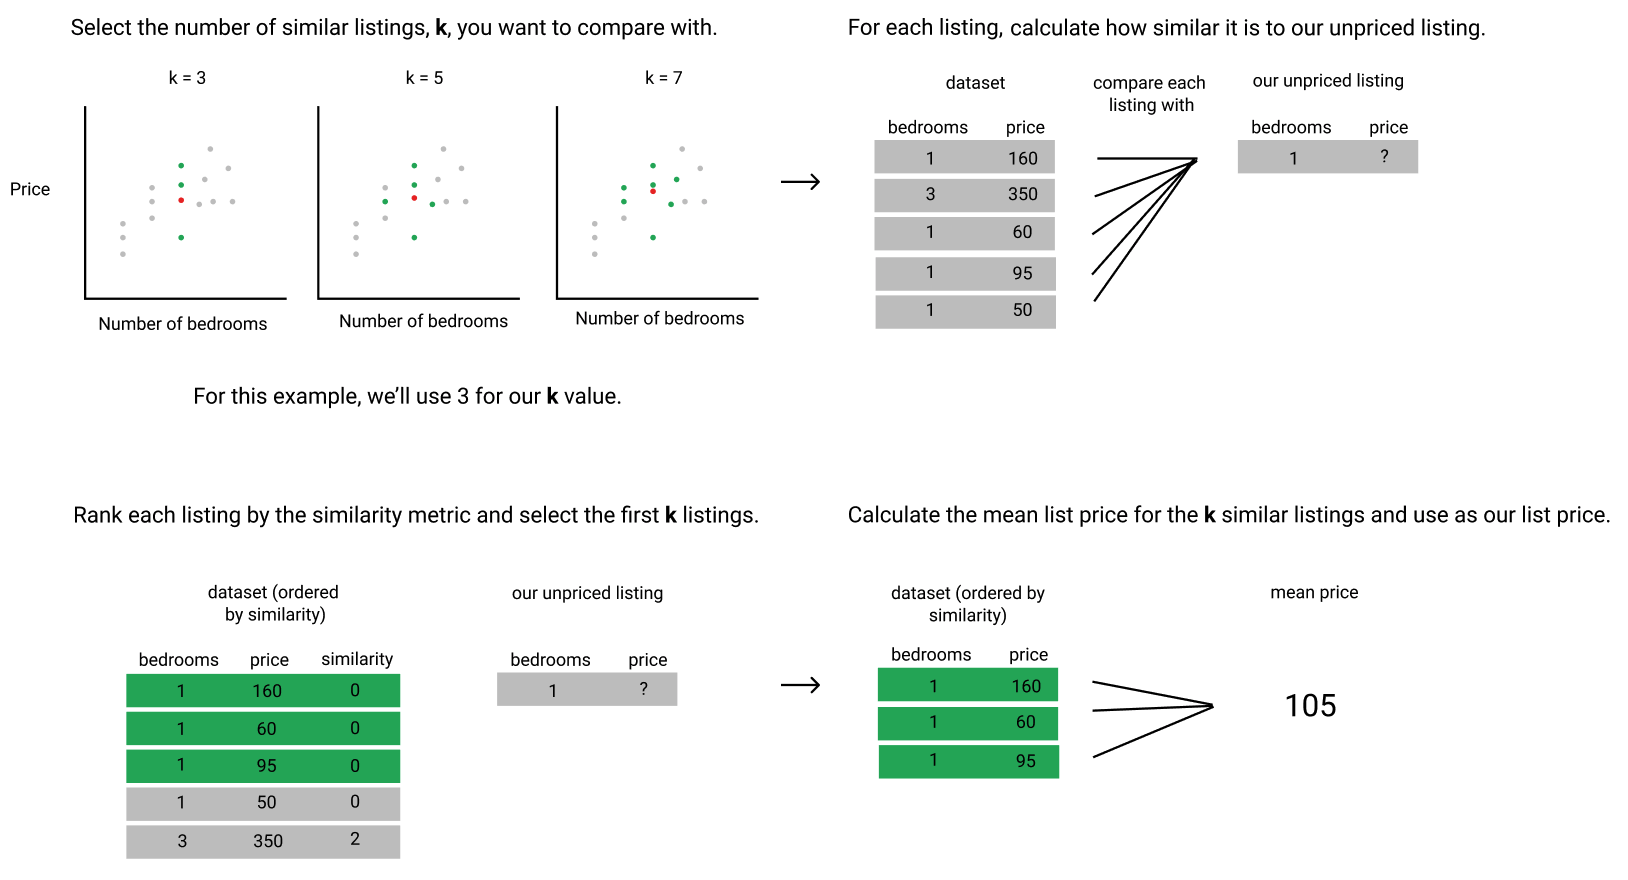

There are 2 things we need to unpack in more detail:

- the similarity metric
- how to choose the k value

In this mission, we'll define what similarity metric we're going to use. Then, we'll implement the k-nearest neighbors algorithm and use it to suggest a price for a new, unpriced listing. We'll use a k value of 5 in this mission. In later missions, we'll learn how to evaluate how good the suggested prices are, how to choose the optimal k value, and more.

The similarity metric works by comparing a fixed set of numerical features, another word for attributes, between 2 observations, or living spaces in our case. When trying to predict a continuous value, like price, the main similarity metric that's used is Euclidean distance. Here's the general formula for Euclidean distance:

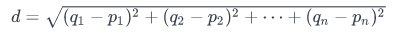

where q1 to qn represent the feature values for one observation and  to represent the feature values for the other observation. Here's a diagram that breaks down the Euclidean distance between the first 2 observations in the dataset using only the host_listings_count, accommodates, bedrooms, bathrooms, and beds columns:

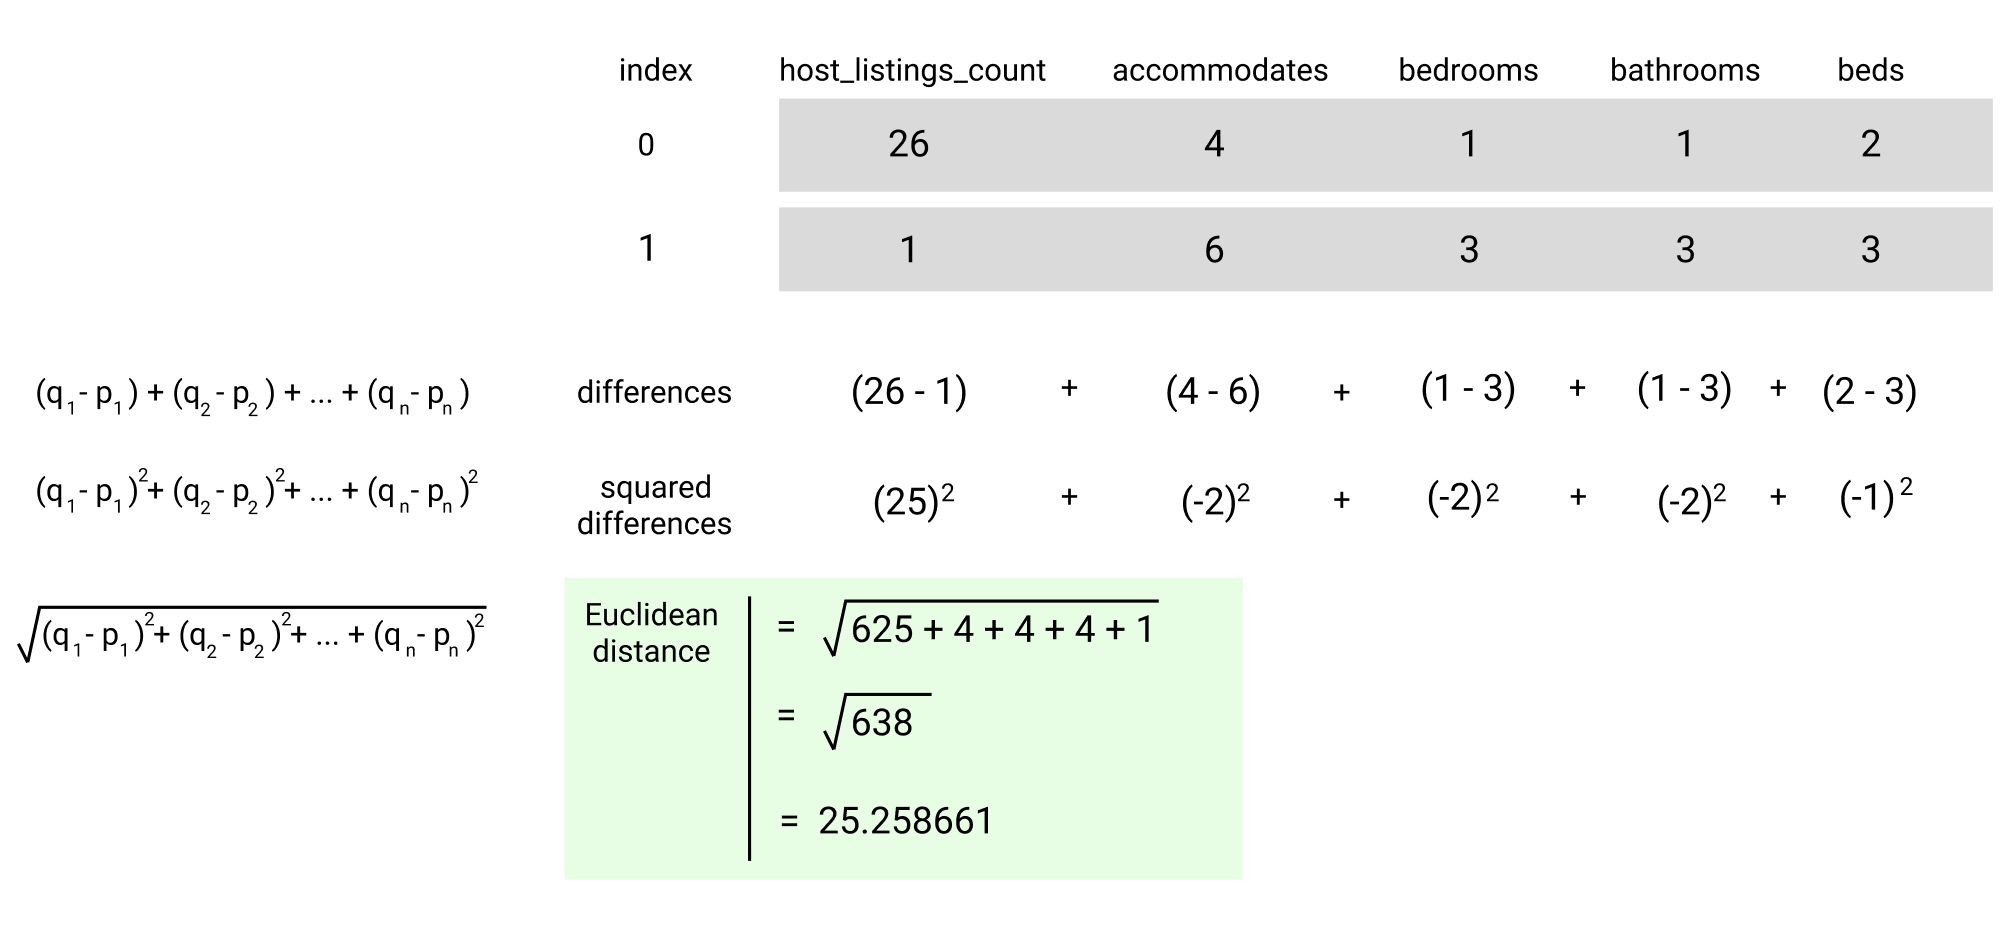

In this mission, we'll use just one feature in this mission to keep things simple as you become familiar with the machine learning workflow. Since we're only using one feature, this is known as the univariate case. Here's how the formula looks like for the univariate case:

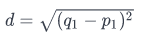

The square root and the squared power cancel and the formula simplifies to:

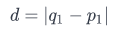

The living space that we want to rent can accommodate 3 people. Let's first calculate the distance, using just the accommodates feature, between the first living space in the dataset and our own.

In [4]:
our_acc_value = 3
first_living_space_value = dc_listings.iloc[0]['accommodates']
first_distance = np.abs(first_living_space_value - our_acc_value)
print(first_distance)

1


The Euclidean distance between the first row in the dc_listings Dataframe and our own living space is 1. How do we know if this is high or low? If you look at the Euclidean distance equation itself, the lowest value you can achieve is 0. This happens when the value for the feature is exactly the same for both observations you're comparing. If p1=q1, then d=|q1-p1| which results in d=0. The closer to 0 the distance the more similar the living spaces are.

If we wanted to calculate the Euclidean distance between each living space in the dataset and a living space that accommodates 8 people, here's a preview of what that would look like:

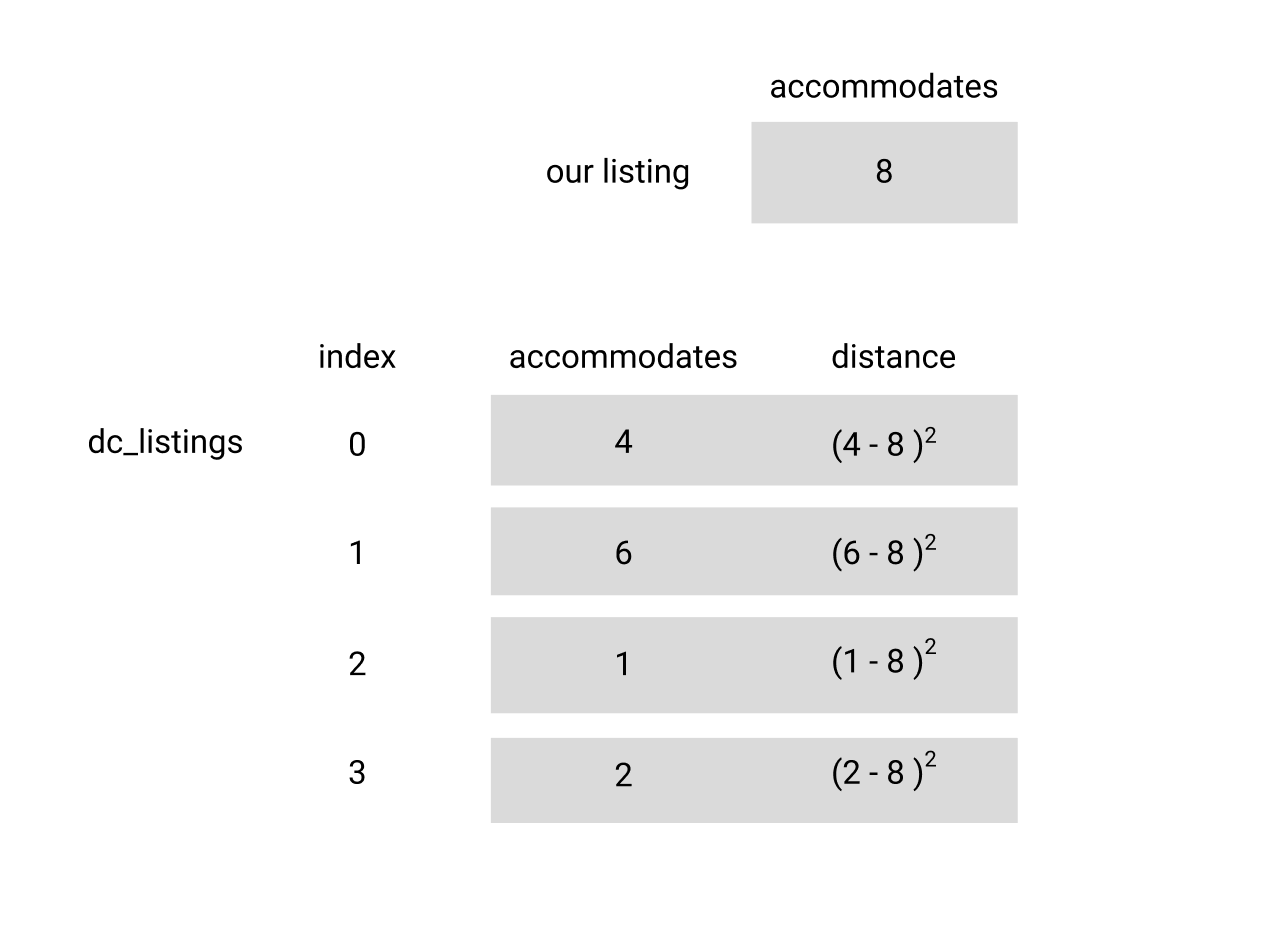

Then, we can rank the existing living spaces by ascending distance values, the proxy for similarity.

In [5]:
new_listing = 3
dc_listings['distance'] = dc_listings['accommodates'].apply(lambda x: np.abs(x - new_listing))
print(dc_listings['distance'].value_counts())

1     2294
2      503
0      461
3      279
5       73
4       35
7       22
6       17
9       12
13       8
8        7
12       6
11       4
10       2
Name: distance, dtype: int64


C:\Users\user\Miniconda3\envs\av\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


It looks like there are quite a few, 461 to be precise, living spaces that can accommodate 3 people just like ours. This means the 5 "nearest neighbors" we select after sorting all will have a distance value of 0. If we sort by the distance column and then just select the first 5 living spaces, we would be biasing the result to the ordering of the dataset.

In [6]:
dc_listings[dc_listings["distance"] == 0]["accommodates"]

26      3
34      3
36      3
40      3
44      3
45      3
48      3
65      3
66      3
71      3
75      3
86      3
103     3
104     3
108     3
115     3
124     3
125     3
129     3
130     3
131     3
133     3
136     3
140     3
146     3
147     3
150     3
151     3
162     3
164     3
       ..
3437    3
3451    3
3478    3
3488    3
3506    3
3510    3
3514    3
3515    3
3546    3
3555    3
3560    3
3568    3
3572    3
3578    3
3582    3
3593    3
3603    3
3612    3
3619    3
3625    3
3626    3
3631    3
3640    3
3651    3
3667    3
3675    3
3697    3
3707    3
3714    3
3722    3
Name: accommodates, Length: 461, dtype: int64

Let's instead randomize the ordering of the dataset and then sort the Dataframe by the distance column. This way, all of the living spaces with the same number of bedrooms will still be at the top of the Dataframe but will be in random order across the first 461 rows. We've already done the first step of setting the random seed, so we can perform answer checking on our end.

In [7]:
np.random.seed(1)
dc_listings = dc_listings.loc[np.random.permutation(len(dc_listings))]
dc_listings = dc_listings.sort_values('distance')
print(dc_listings.iloc[0:10]['price'])

577     $185.00
2166    $180.00
3631    $175.00
71      $128.00
1011    $115.00
380     $219.00
943     $125.00
3107    $250.00
1499     $94.00
625     $150.00
Name: price, dtype: object


Before we can select the 5 most similar living spaces and compute the average price, we need to clean the price column. Right now, the price column contains comma characters (,) and dollar sign characters and is formatted as a text column instead of a numeric one. We need to remove these values and convert the entire column to the float datatype. Then, we can calculate the average price.

In [8]:
stripped_commas = dc_listings['price'].str.replace(',', '')
stripped_dollars = stripped_commas.str.replace('$', '')
dc_listings['price'] = stripped_dollars.astype('float')
mean_price = dc_listings.iloc[0:5]['price'].mean()
print(mean_price)

156.6


Based on the average price of other listings that accommdate 3 people, we should charge 156.6 dollars per night for a guest to stay at our living space. In the next mission, we'll dive into evaluating how good of a prediction this is.

Let's write a more general function that can suggest the optimal price for other values of the accommodates column. The dc_listings Dataframe has information specific to our living space, e.g. the distance column. To save you time, we've reset the dc_listings Dataframe to a clean slate and only kept the data cleaning and randomization we did since those weren't unique to the prediction we were making for our living space.

In [9]:
# Brought along the changes we made to the `dc_listings` Dataframe.
stripped_dollars = dc_listings['price']
dc_listings['price'] = stripped_dollars.astype('float')
dc_listings = dc_listings.loc[np.random.permutation(len(dc_listings))]

def predict_price(new_listing):
    temp_df = dc_listings.copy()
    temp_df['distance'] = temp_df['accommodates'].apply(lambda x: np.abs(x - new_listing))
    temp_df = temp_df.sort_values('distance')
    nearest_neighbors = temp_df.iloc[0:5]['price']
    predicted_price = nearest_neighbors.mean()
    return(predicted_price)

acc_one = predict_price(1)
acc_two = predict_price(2)
acc_four = predict_price(4)
print(acc_one)
print(acc_two)
print(acc_four)

71.8
96.8
96.0


In this mission, we explored the problem of predicting the optimal price to list an AirBnB rental for based on the price of similar listings on the site. We stepped through the entire machine learning workflow, from selecting a feature to testing the model. To explore the basics of machine learning, we limited ourselves to only using one feature (the univariate case) and a fixed k value of 5.

## Thats all folks!!